##  FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.


In [5]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [6]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 5s 0us/step


(50000, 32, 32, 3)

In [8]:
train_x = train_x.astype('float32')
train_x = (train_x - 127.5)/127.5

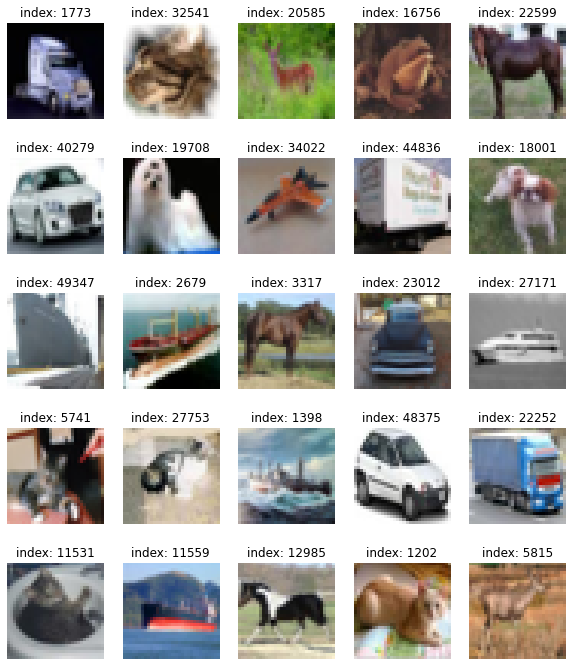

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [77]:
from tensorflow.python.keras import regularizers

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(2*2*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((2, 2, 1024)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    # 출력 차원 256
    # (5,5) 는 kernel_size : 2D 컨볼루션 창의 높이와 너비를 지정하는 정수 또는 2개의 정수로 구성된 튜플
    # "same"결과적으로 출력이 입력과 동일한 높이/너비 치수를 갖도록 입력의 왼쪽/오른쪽 또는 위/아래에 균일하게 0이 채워집니다.
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5),dilation_rate=(1, 1),strides=(2, 2), padding='same', use_bias=False,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5),dilation_rate=(1, 1), strides=(2, 2), padding='same', use_bias=False,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, kernel_size=(3, 3), dilation_rate=(2, 2),strides=(1, 1), padding='same', use_bias=False,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    model.add(layers.Conv2DTranspose(16, kernel_size=(1, 1), dilation_rate=(3, 3),strides=(1, 1), padding='same', use_bias=False,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model


In [78]:
generator = make_generator_model()
generator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 4096)              409600    
_________________________________________________________________
batch_normalization_45 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_transpose_45 (Conv2DT (None, 4, 4, 256)         6553600   
_________________________________________________________________
batch_normalization_46 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 4, 4, 256)       

In [79]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성

noise = tf.random.normal([1, 100])

In [80]:
# 학습이 아니기때문에 False값을 주었다

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

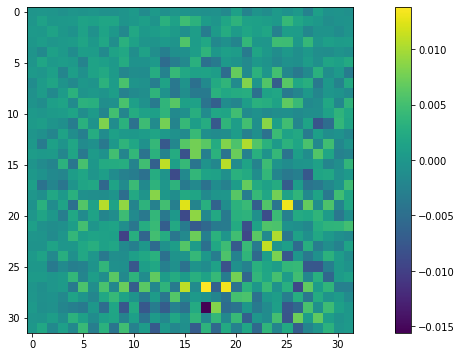

In [81]:
# matplotlib 라이브러리는 2차원 이미지만 출력가능하므로 0번째와 3번째 축의 인덱스를 0으로 설정
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [82]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5),  strides=(2, 2), dilation_rate=(1, 1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2),dilation_rate=(1, 1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2),dilation_rate=(1, 1), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), dilation_rate=(1, 1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

In [83]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 256)       

In [84]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00014725]], dtype=float32)>

## fake_output : 생성자가 생성한 Fake Image를 discriminator 에 입력시켜서 판별된 값, 즉 D(fake_image)

## real_output : 기존에 있던 Real Image를 discriminator 에 입력시켜서 판별된 값, 즉 D(real_image)



### 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다 


### 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을


### 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.(밑 코드 참조) 

In [85]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 

## 즉 D(fake_image)는 0에 가까워지는 것

## loss 는 cross_entropy 로 진짜/가짜 분류


#### generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.

In [86]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 

### 바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 됩니다.
### 이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용합니다.

### 반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 
### 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교

In [87]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [88]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [89]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)

In [90]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### 하나의 미니 배치 당 진행할 train_step 함수를 먼저 만들어야 합니다.

### 텐서플로우 2.0 이후부터는 1.x의 이전 버전과 다르게, session을 사용하지 않습니다. 

### 대신, 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용합니다. 

### 이 데코레이터는 우리가 직접 session을 열어서 학습했다가,

### 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해줍니다.

In [91]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈(3)
        # tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        # discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 
        # real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산 
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    # gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [92]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2.0)
        plt.axis('off')
        
    #  plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장합니다. 
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [93]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [94]:
# 체크포인트가 저장될 디렉토리
checkpoint_dir = '/aiffel/aiffel/dcgan_newimage/cifar10/training_checkpoints'

# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [95]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))#(현재시간-아까쟀던 시간)으로 소요시간 측정

        draw_train_history(history, epoch)

## 학습시키고 이 두 코드 를 다시 동작하면 그 전 결과에서부터 학습이 됨을 확인하였다 

In [105]:

save_every = 5
EPOCHS = 90  

tf.config.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

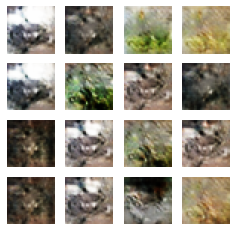

Time for training : 3127 sec


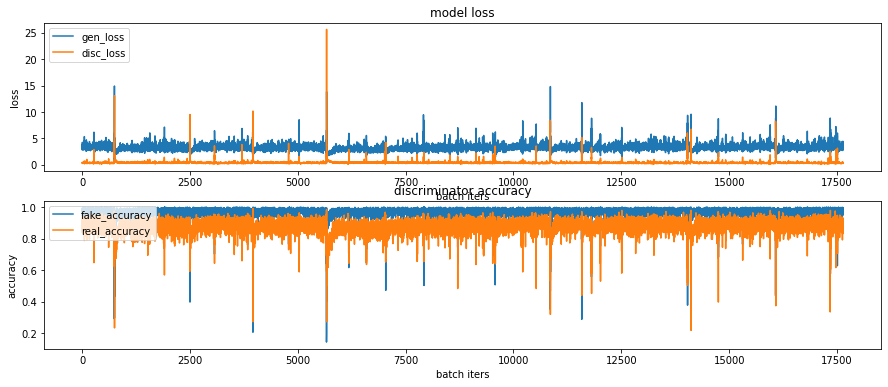

CPU times: user 55min 16s, sys: 3min 23s, total: 58min 40s
Wall time: 52min 8s


In [106]:
%%time
train(train_dataset, EPOCHS, save_every)

## GIF 파일은 우리가 오래전에 import 해놓았던 imageio 라이브러리를 활용해 만들 수 있습니다.
## imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식입니다.

In [33]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1048572 Feb  8 02:43 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


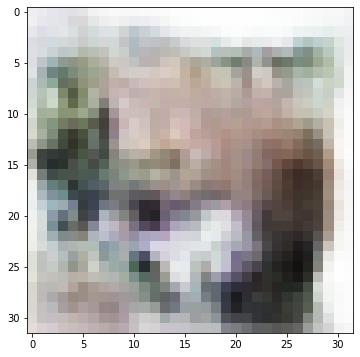

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newi mage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# np_generated = generated_image.numpy()
# np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
# np_generated = np_generated.astype(int)
plt.imshow((generated_image[0]+1)/2.0)
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [ ]:
# 회고
## GAN 에 대한 실제적인 코드를 작성할 수 있었으며, gif 파일로 저장, 체크포인트 등 실제적 내용을 배웠다.
## 성능향상을 위해서 adam optimizer의 learning rate를 2e-4로 설정하고, beta1을 0.5로 설정하였습니다.